# Основные критерии оценки за задание

- аккуратность оформления работы;
- наличие выводов;
- обоснованность выбора статистических критериев, учет поправки на множественность гипотез
- в случае работы с синтетическими данными: учет неточностей, связанных со случайным порождением данных
- в случае работы с реальными данными также учитывается предобработка

In [2]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('enter phystech e-mail\n') 
    to_hash =  mail.strip().split('@')[0]    
    h = crc32(to_hash.encode('utf-8')) + 127
    seed = h%(2**32-1)
    rs = np.random.RandomState(seed)
    task1 = rs.randint(low=1, high=5)
    task2 = rs.randint(low=1, high=5)
    print ('Your tasks are 1.{}, 2.{}'.format(task1, task2))

enter phystech e-mail
usmanova.aa@phystech.edu
Your tasks are 1.2, 2.3


# Задача 1.2

Выборка: Архив записей голоса

Требуется:

- Отобрать записи, соответствующие странам с минимум 30 респонеднтами в выборке.
- Получить сумму zero-crossing по каждой из записей.
- Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости 0.15. Дискретность признака zero-crossing игнорировать.

### 1. Отбор записей, соответствующим странам с минимум 30 респонеднтами в выборке

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

np.random.seed(17)

In [50]:
data = pd.read_csv('speakers_all.csv')
print('Всего записей в таблице = ', len(data))
data.head()

Всего записей в таблице =  2172


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [51]:
#Удалим записи в таблице, аудиодорожки которых отсутствуют.
data = data[data['file_missing?'] == False]

In [52]:
#А также столбцы "Unnamed", так как они не несут за собой полезной информации.
print(data['Unnamed: 9'].value_counts())
print(data['Unnamed: 10'].value_counts())
print(data['Unnamed: 11'].value_counts())
del data['Unnamed: 9']
del data['Unnamed: 10']
del data['Unnamed: 11']

Series([], Name: Unnamed: 9, dtype: int64)
Series([], Name: Unnamed: 10, dtype: int64)
no    1
Name: Unnamed: 11, dtype: int64


Отберем страны с минимум 30 респондентами.

In [61]:
df = pd.DataFrame(data['country'].value_counts())
df.index.name = 'country'
df.columns = ['count']
df = df[df['count'] >=30]
df

,count
country,
usa,391
china,88
uk,67
india,58
canada,54
south korea,51
brazil,39
belgium,36
turkey,35


In [62]:
data = data[data['country'].isin(list(df.index))]
print('После предобработки записей =',len(data))
data.head()

После предобработки записей = 1045


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False
51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False
52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False
53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False
54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False


In [65]:
#Проверка на дублирующиеся записи (их нет)
assert len(list(data['speakerid'].value_counts())) == len(data)

Разобьем респондентов по группам родного языка. Для этого оствавим в выборке языки, количество представителей которых имеют их в качестве родного больше 10. И разделим языки на 3 группы:

- английский (в качестве оригинального языка текста) (english)
- языки стран Европы (european)
- языки стран Азии (asian)

In [44]:
data['native_language'].value_counts() > 10

df = pd.DataFrame(data['native_language'].value_counts())
df.index.name = 'native'
df.columns = ['count']
df = df[df['count'] >10]

data = data[data['native_language'].isin(list(df.index))]
print(len(data))
europe_list = ['portuguese', 'polish', 'italian', 'russian', 'dutch', 'german', 'french']
asia_list = ['mandarin', 'korean', 'arabic', 'turkish', 'cantonese', 'amharic', 'hindi' ]
language_list = []
for lang in list(data['native_language']):
    if lang == 'english':
        language_list.append('english')
    if lang in europe_list:
        language_list.append('european')
    if lang in asia_list:
        language_list.append('asian')
data['native3'] = language_list
data.head(1)

961


,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_cross,native3
0,50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,67652,asian


Также разобьем респондентов по возрастным категориям: 

-  до 25 (young)

- от 25 до 40 (middle)

- от 40 (old)


In [45]:
data['age'].describe()

count    961.000000
mean      32.480229
std       15.167146
min        6.000000
25%       21.000000
50%       27.000000
75%       39.000000
max       97.000000
Name: age, dtype: float64

In [48]:
print('до 25 =', len(data[data['age']<25])) 
print('от 25 до 40 =',len(data[(data['age']<40)  & (data['age']>=25)]))
print('от 40 = ' ,len(data[data['age']>=40]))

до 25 = 394
от 25 до 40 = 332
от 40 =  235


In [49]:
ages = []
for age in data['age']:
    if age < 25:
        ages.append('young')
    elif age >= 40:
        ages.append('old')
    else: 
        ages.append('middle')
data['age3'] = ages

### 2. Получение суммы zero-crossing по каждой из записей

In [69]:
import librosa

In [70]:
name_list = list(data['filename'])
audio_path  = 'speech-accent-archive/recordings/recordings/'

In [73]:
zero_crossings = []
for name in name_list:
    x, sr = librosa.load(audio_path + name + '.mp3')
    zero_crossings.append(sum(librosa.zero_crossings(x, pad=False)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/libros

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [81]:
data['zero_cross'] = zero_crossings
data.head(1)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_cross
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,67652


### 3. Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости 0.15. Дискретность признака zero-crossing игнорировать.

In [50]:
data.head()

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_cross,native3,age3
0,50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,67652,asian,young
1,51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,73626,asian,middle
2,52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,80456,asian,young
3,53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,64522,asian,middle
4,54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,103746,asian,middle


- variable - zero-crossing
- factors - age3, native3, sex

=> применяем трехфакторный дисперсионный анализ

# Tрехфакторный дисперсионный анализ

In [51]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
%matplotlib inline

In [52]:
lm = ols('zero_cross ~  C(native3) * C(sex) * C(age3) ', data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native3),2.0,4.601421e+10,2.300710e+10,30.363831,1.661000e-13
C(sex),1.0,1.354922e+10,1.354922e+10,17.881708,2.579606e-05
C(age3),2.0,1.143280e+10,5.716400e+09,7.544270,5.616959e-04
C(native3):C(sex),2.0,1.344785e+08,6.723925e+07,0.088740,9.150915e-01
C(native3):C(age3),4.0,6.606858e+09,1.651715e+09,2.179865,6.937254e-02
C(sex):C(age3),2.0,2.851786e+09,1.425893e+09,1.881835,1.528819e-01
C(native3):C(sex):C(age3),4.0,1.392494e+09,3.481236e+08,0.459439,7.655390e-01
Residual,943.0,7.145244e+11,7.577141e+08,NaN,NaN


In [53]:
#Значимые взаимодействия
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native3),2.0,4.601421e+10,2.300710e+10,30.363831,1.661000e-13
C(sex),1.0,1.354922e+10,1.354922e+10,17.881708,2.579606e-05
C(age3),2.0,1.143280e+10,5.716400e+09,7.544270,5.616959e-04
C(native3):C(age3),4.0,6.606858e+09,1.651715e+09,2.179865,6.937254e-02


Тройное взаимодействие незначимо, но есть значимое межфакторное взаимодействие.

In [82]:
#Значимое двухфакторное взаимодействие
lm = ols('zero_cross ~  C(native3)* C(age3) ', data=data).fit()
table = sm.stats.anova_lm(lm)
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native3),2.0,4.601421e+10,2.300710e+10,29.909924,2.523870e-13
C(age3),2.0,1.143281e+10,5.716405e+09,7.431498,6.273015e-04
C(native3):C(age3),4.0,6.768446e+09,1.692111e+09,2.199795,6.716857e-02


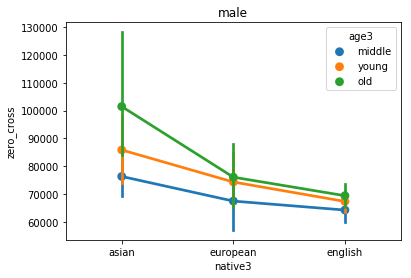

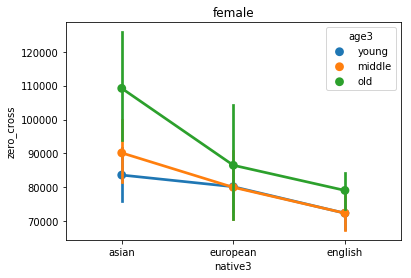

In [54]:
plt.title('male')
sns.pointplot(x="native3", y="zero_cross", data=data.loc[data['sex']=='male'], hue='age3')

plt.show()
plt.title('female')
sns.pointplot(x="native3", y="zero_cross", data=data.loc[data['sex']=='female'], hue='age3')

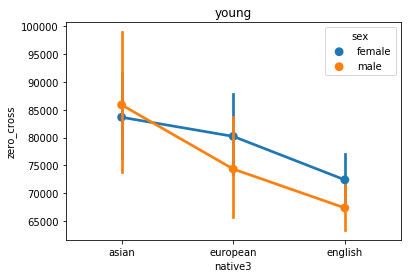

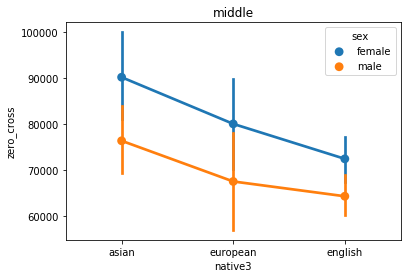

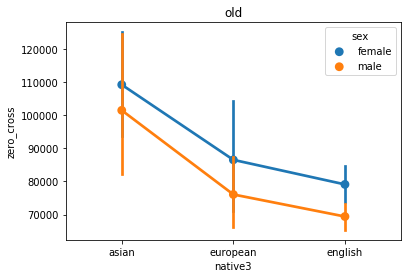

In [92]:
plt.title('young')
sns.pointplot(x="native3", y="zero_cross", data=data.loc[data['age3']=='young'], hue='sex')

plt.show()
plt.title('middle')
sns.pointplot(x="native3", y="zero_cross", data=data.loc[data['age3']=='middle'], hue='sex')

plt.show()
plt.title('old')
sns.pointplot(x="native3", y="zero_cross", data=data.loc[data['age3']=='old'], hue='sex')

#### Как видно, из графиков:

- носители английского языка, имеют меньшее значение zero-crossing
- женщнины, являющиеся носителями и европейцами, молодого и среднего возраста имеют zero-crossing примерно на одном уровне 
- пожилые представители стран Азии имеют наибольшее значение zero-crossing респондентов
- в основном, женщины имеют zero-crossing больше, чем мужчины, вне зависимости от возраста (кроме молодых азиатов)

Разобьем выборку по языковой принадлежности.

## Двухфакторный дисперсионный анализ для разных языковых групп

In [68]:
for lang in ['english', 'european', 'asian']:
    lm = ols('zero_cross ~ C(age3) * C(sex)', data=data[data['native3'] == str(lang)]).fit()
    table = sm.stats.anova_lm(lm)
    print(lang)
    print(table[table['PR(>F)'] < 0.15])
    print('\n')

english
          df        sum_sq       mean_sq          F    PR(>F)
C(age3)  2.0  3.040936e+09  1.520468e+09   3.226834  0.040490
C(sex)   1.0  7.114793e+09  7.114793e+09  15.099466  0.000115


european
         df        sum_sq       mean_sq         F    PR(>F)
C(sex)  1.0  3.945248e+09  3.945248e+09  4.138639  0.043255


asian
          df        sum_sq       mean_sq         F    PR(>F)
C(age3)  2.0  1.412782e+10  7.063908e+09  5.774915  0.003566




Значимого межфакторного взаимодействия нет.

#### Исследуем попарное влияние пола и возраста на носителей английского.

In [86]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [89]:
mc = MultiComparison(
                    data[data['native3'] == 'english']['zero_cross'], 
                    data[data['native3'] == 'english']['sex'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
female   male -7473.7596 0.001 -11240.2081 -3707.3112   True
------------------------------------------------------------


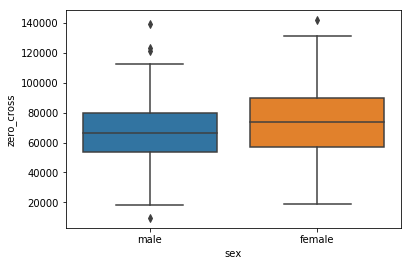

In [110]:
sns.boxplot(x='sex', y='zero_cross', data=data[(data['native3']=='english')])

In [90]:
mc = MultiComparison(
                    data[data['native3'] == 'english']['zero_cross'], 
                    data[data['native3'] == 'english']['age3'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper    reject
-----------------------------------------------------------
middle    old 5928.9927 0.0428   150.2442 11707.7412   True
middle  young 1519.8876 0.7689 -3929.5022  6969.2775  False
   old  young -4409.105 0.1469 -9934.5641  1116.3541  False
-----------------------------------------------------------


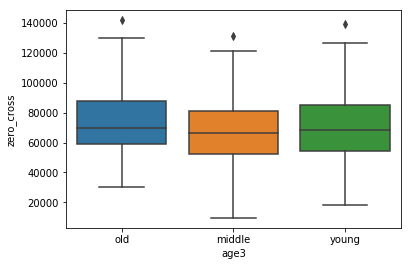

In [111]:
sns.boxplot(x='age3', y='zero_cross', data=data[(data['native3']=='english')])

- У женщин-носителей значение zero-crossing выше, чем у мужчин-носителей, в среднем на 7.5k.
- У пожилых носителй значение zero-crossing выше, чем у middle age, в среднем на 6k. 

#### Исследуем попарное влияние пола и возраста на респондентой европейской и азиатской языковых категорий.

In [94]:
mc = MultiComparison(
                    data[data['native3'] == 'european']['zero_cross'], 
                    data[data['native3'] == 'european']['sex'])
result = mc.tukeyhsd()
print(result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj     lower     upper  reject
----------------------------------------------------------
female   male -8458.0389 0.0512 -16959.8652 43.7873  False
----------------------------------------------------------


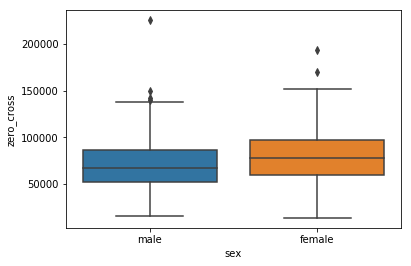

In [113]:
sns.boxplot(x='sex', y='zero_cross', data=data[(data['native3']=='european')])

In [95]:
mc = MultiComparison(
                    data[data['native3'] == 'asian']['zero_cross'], 
                    data[data['native3'] == 'asian']['age3'])
result = mc.tukeyhsd()
print(result)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
middle    old  22342.2395 0.0035  6220.4586 38464.0205   True
middle  young   1419.2964    0.9 -10188.027 13026.6197  False
   old  young -20922.9432 0.0078 -37248.268 -4597.6183   True
-------------------------------------------------------------


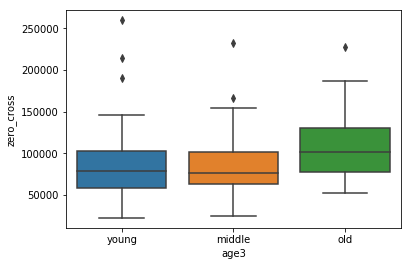

In [115]:
sns.boxplot(x='age3', y='zero_cross', data=data[(data['native3']=='asian')])

- Пожилые азиаты имеют в среднем на 21к больше значение zero-crossing, чем молодые, и на 22к больше, чем среднего возраста.

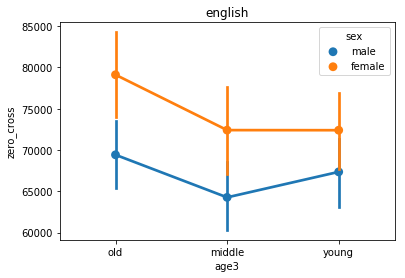

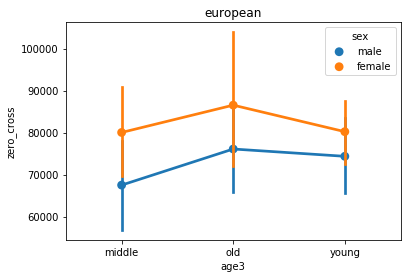

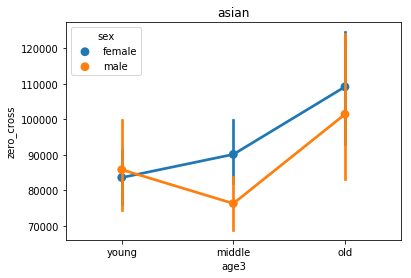

In [69]:
plt.title('english')
sns.pointplot(x="age3", y="zero_cross", data=data.loc[data['native3']=='english'], hue='sex')

plt.show()
plt.title('european')
sns.pointplot(x="age3", y="zero_cross", data=data.loc[data['native3']=='european'], hue='sex')

plt.show()
plt.title('asian')
sns.pointplot(x="age3", y="zero_cross", data=data.loc[data['native3']=='asian'], hue='sex')

## Двухфакторный дисперсионный анализ для разных возрастов

In [70]:
for age in ['young', 'middle', 'old']:
    lm = ols('zero_cross ~ C(native3) * C(sex)', data=data[data['age3'] == str(age)]).fit()
    table = sm.stats.anova_lm(lm)
    print(age)
    print(table[table['PR(>F)'] < 0.15])
    print('\n')

young
             df        sum_sq       mean_sq         F    PR(>F)
C(native3)  2.0  1.539557e+10  7.697783e+09  9.492226  0.000094


middle
             df        sum_sq       mean_sq          F    PR(>F)
C(native3)  2.0  1.502455e+10  7.512276e+09  10.666797  0.000033
C(sex)      1.0  9.611517e+09  9.611517e+09  13.647541  0.000259


old
             df        sum_sq       mean_sq          F        PR(>F)
C(native3)  2.0  2.865818e+10  1.432909e+10  19.270147  1.841193e-08
C(sex)      1.0  5.325699e+09  5.325699e+09   7.162143  7.983898e-03




Значимого межфакторного взаимодействия нет.

#### Исследуем попарное различие пола и языка для пожилых респондентов.

In [96]:
mc = MultiComparison(
                    data[data['age3'] == 'old']['zero_cross'], 
                    data[data['age3'] == 'old']['sex'])
result = mc.tukeyhsd()
print(result)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
female   male -10550.3523 0.006 -18044.6616 -3056.0431   True
-------------------------------------------------------------


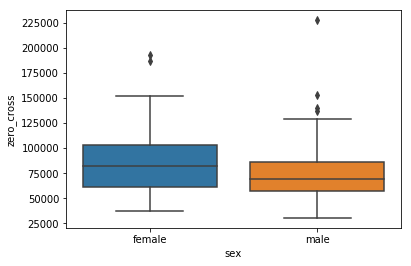

In [109]:
sns.boxplot(x='sex', y='zero_cross', data=data[(data['age3']=='old')])

In [98]:
mc = MultiComparison(
                    data[data['age3'] == 'old']['zero_cross'], 
                    data[data['age3'] == 'old']['native3'])
result = mc.tukeyhsd()
print(result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1  group2    meandiff  p-adj    lower       upper    reject
-----------------------------------------------------------------
  asian  english -31642.3399 0.001 -43782.4816 -19502.1982   True
  asian european -24834.9506 0.001 -39536.2791 -10133.6222   True
english european   6807.3893 0.318  -4272.3554   17887.134  False
-----------------------------------------------------------------


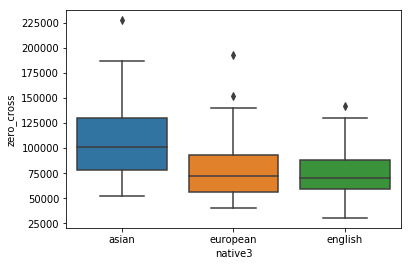

In [108]:
sns.boxplot(x='native3', y='zero_cross', data=data[(data['age3']=='old')])

- Пожилые женщины имеют значение zero-crossing больше, чем мужчины.
- Пожилые азиаты имеют значение zero-crossing больше, чем пожилые европейцы на 24,5к и больше, чем пожилые носители на 31к. 

#### Исследуем различие в воздействии пола и языка для респондентов среднего возраста.

In [100]:
mc = MultiComparison(
                    data[data['age3'] == 'middle']['zero_cross'], 
                    data[data['age3'] == 'middle']['sex'])
result = mc.tukeyhsd()
print(result)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
female   male -10550.3523 0.006 -18044.6616 -3056.0431   True
-------------------------------------------------------------


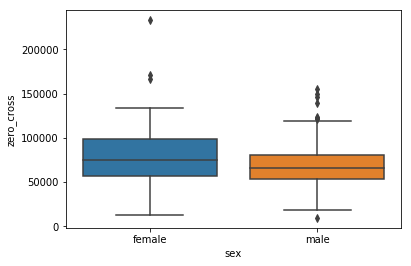

In [106]:
sns.boxplot(x='sex', y='zero_cross', data=data[(data['age3']=='middle')])

In [105]:
mc = MultiComparison(
                    data[data['age3'] == 'middle']['zero_cross'], 
                    data[data['age3'] == 'middle']['native3'])
result = mc.tukeyhsd()
print(result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1  group2    meandiff  p-adj     lower      upper    reject
-----------------------------------------------------------------
  asian  english -15229.0931  0.001  -23128.188 -7329.9981   True
  asian european    -8847.96 0.1038 -19045.7095  1349.7894  False
english european    6381.133 0.2578  -3151.4571 15913.7232  False
-----------------------------------------------------------------


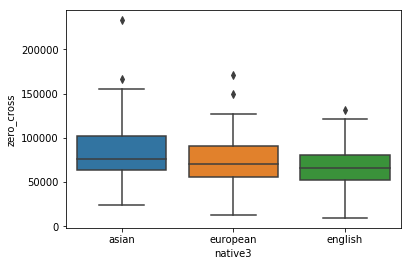

In [107]:
sns.boxplot(x='native3', y='zero_cross', data=data[(data['age3']=='middle')])

- Женщины среднего возраста имеют значение zero-crossing на 10к больше, чем мужчины среднего возраста.
- Азиаты среднего возраста имеют значение zero-crossing на 8.8к больше, чем носители среднего возраста.

#### Исследуем попарное различие языка для молодых респондентов.

In [102]:
mc = MultiComparison(
                    data[data['age3'] == 'young']['zero_cross'], 
                    data[data['age3'] == 'young']['native3'])
result = mc.tukeyhsd()
print(result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1  group2    meandiff  p-adj     lower      upper    reject
-----------------------------------------------------------------
  asian  english -15128.5018  0.001 -23422.4382 -6834.5654   True
  asian european  -7643.6977 0.1475 -17236.5035  1949.1081  False
english european   7484.8041 0.0851   -780.6344 15750.2427  False
-----------------------------------------------------------------


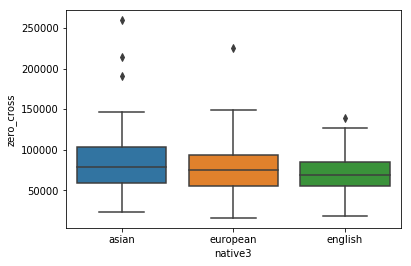

In [104]:
sns.boxplot(x='native3', y='zero_cross', data=data[(data['age3']=='young')])

- Молодые азиаты  имеют значение zero-crossing на 15к больше, чем молодые носители английского.

## Однофакторный анализ для всей выборки

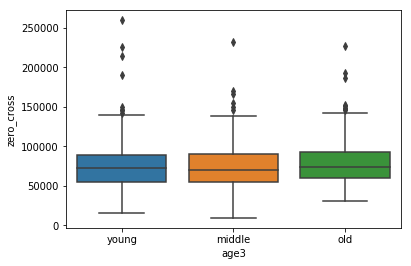

In [116]:
sns.boxplot(x='age3', y='zero_cross', data=data)

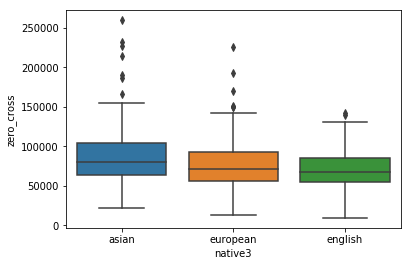

In [117]:
sns.boxplot(x='native3', y='zero_cross', data=data)

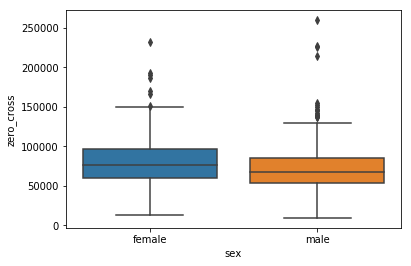

In [118]:
sns.boxplot(x='sex', y='zero_cross', data=data)

# Вывод: 

- Носители английского языка, имеют меньшее значение zero-crossing.
- В основном, женщины имеют zero-crossing больше, чем мужчины, вне зависимости от возраста (кроме молодых азиатов).


- Пожилые азиаты имеют в среднем на 21к больше значение zero-crossing, чем молодые, и на 22к больше, чем среднего возраста.
- Пожилые азиаты имеют значение zero-crossing больше, чем пожилые европейцы на 24,5к и больше, чем пожилые носители на 31к. 
- Азиаты среднего возраста имеют значение zero-crossing на 8.8к больше, чем носители среднего возраста.